# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [9]:
!git clone https://github.com/oristides/deep-learning.git

Cloning into 'deep-learning'...
remote: Counting objects: 1443, done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 1443 (delta 0), reused 0 (delta 0), pack-reused 1434
Receiving objects: 100% (1443/1443), 47.80 MiB | 24.28 MiB/s, done.
Resolving deltas: 100% (603/603), done.


In [10]:
!pip install tqdm

In [0]:
import os
os.chdir("deep-learning/face_generation/")

In [18]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0k/60.0k [00:12<00:00, 4.64kFile/s]

Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

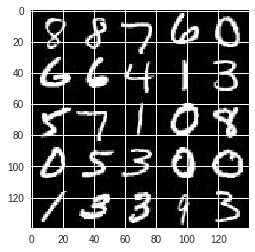

In [19]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'))

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

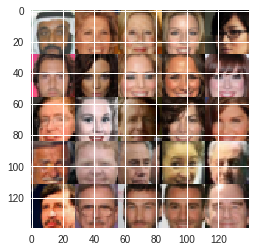

In [20]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [21]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.9.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [22]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, shape=[None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [117]:
def discriminator(images, reuse=False, alpha= 0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        x = tf.layers.conv2d(images, 32, 5, 2,'same', use_bias=True, activation=None, kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        x = tf.maximum(alpha * x, x)
        
        x = tf.layers.conv2d(x, 64, 5, 2,'same', use_bias=True, activation=None, kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        x = tf.layers.batch_normalization(x, training=True)
        x =  tf.layers.dropout(x, 0.05)
        x = tf.maximum(alpha * x, x)
        
        x = tf.layers.conv2d(x, 128, 5, 2,'same', use_bias=True, activation=None, kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        x = tf.layers.batch_normalization(x, training=True)
        x =  tf.layers.dropout(x, 0.05)
        x = tf.maximum(alpha * x, x)

        x = tf.reshape(x, (-1, 4*4*128))
        
        logits = tf.layers.dense(x, 1, activation=None)
        output = tf.sigmoid(logits)
        
    return output, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [116]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        x = tf.layers.dense(z, 3*3*512, use_bias=True, activation=None)
        x = tf.reshape(x, (-1, 3, 3, 512))
        x = tf.layers.batch_normalization(x, training=is_train)
        x =  tf.layers.dropout(x, 0.05)
        x = tf.maximum(alpha * x, x)
        
        # 3x3x256
        
        x = tf.layers.conv2d_transpose(x, 256, 5, 2,'same', use_bias=True, activation=None, kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        x = tf.layers.batch_normalization(x, training=is_train)
        x =  tf.layers.dropout(x, 0.05)
        x = tf.maximum(alpha * x, x)
        # 6x6x 128
        
        x = tf.layers.conv2d_transpose(x, 128, 5, 2,'same', use_bias=True, activation=None, kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        # 14x14x64
        
        x = tf.layers.conv2d_transpose(x, out_channel_dim, 6, 2,'valid', activation=None, kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        out = tf.tanh(x)
        # 28x28xout_channel_dim
        
    return out



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [118]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [119]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    t_vars = tf.trainable_variables()
    d_vars = [v for v in t_vars if v.name.startswith('discriminator')]
    g_vars = [v for v in t_vars if v.name.startswith('generator')]
    

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [0]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode ):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [0]:
import time

In [0]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    init_time=time.time()
    samples, losses = [], []
    if data_image_mode=='L':
      ima_channel=1
      input_real, input_z, learn_rate = model_inputs(28, 28, ima_channel, z_dim)
      d_loss, g_loss = model_loss(input_real, input_z, 1)
    else:
      ima_channel=3
      input_real, input_z, learn_rate = model_inputs(28, 28, ima_channel, z_dim)
      d_loss, g_loss = model_loss(input_real, input_z, 3)
    
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    b_size=batch_size
    steps=0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
              steps += 1
              # Sample random noise for G
              batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
              
              # Run optimizers, 
              _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
              _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

              if steps % 60 == 0:
                  # At the end of each epoch, get the losses and print them out
                  train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                  train_loss_g = g_loss.eval({input_z: batch_z})
                  

                  print("Epoch {}/{}...".format(epoch_i+1, epochs),
                        "Batches {}/{}...".format(int(b_size*steps/(epoch_i+1)), data_shape[0]),
                        "Discriminator Loss: {:.4f}...".format(train_loss_d),
                        "Generator Loss: {:.4f}".format(train_loss_g),
                         "Time_mins: {:.0f}".format((time.time()-init_time)/60))
                  # Save losses to view after training
              
              if steps % 600 == 0:
                show_generator_output(sess, 25, input_z, ima_channel, data_image_mode)
            
           

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batches 3840/60000... Discriminator Loss: 3.0374... Generator Loss: 0.0637 Time_mins: 0
Epoch 1/2... Batches 7680/60000... Discriminator Loss: 1.3425... Generator Loss: 5.5260 Time_mins: 0
Epoch 1/2... Batches 11520/60000... Discriminator Loss: 1.5131... Generator Loss: 7.5051 Time_mins: 0
Epoch 1/2... Batches 15360/60000... Discriminator Loss: 0.4275... Generator Loss: 1.4073 Time_mins: 0
Epoch 1/2... Batches 19200/60000... Discriminator Loss: 0.5366... Generator Loss: 1.5442 Time_mins: 1
Epoch 1/2... Batches 23040/60000... Discriminator Loss: 0.3584... Generator Loss: 1.7842 Time_mins: 1
Epoch 1/2... Batches 26880/60000... Discriminator Loss: 0.4306... Generator Loss: 1.5722 Time_mins: 1
Epoch 1/2... Batches 30720/60000... Discriminator Loss: 1.1983... Generator Loss: 0.6516 Time_mins: 1
Epoch 1/2... Batches 34560/60000... Discriminator Loss: 0.1725... Generator Loss: 2.3415 Time_mins: 1
Epoch 1/2... Batches 38400/60000... Discriminator Loss: 0.0873... Generator Loss: 3.

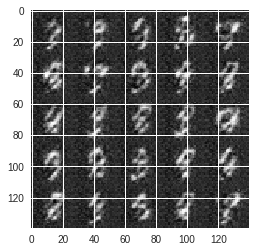

Epoch 1/2... Batches 42240/60000... Discriminator Loss: 0.3229... Generator Loss: 1.9591 Time_mins: 1
Epoch 1/2... Batches 46080/60000... Discriminator Loss: 0.1280... Generator Loss: 2.6573 Time_mins: 1
Epoch 1/2... Batches 49920/60000... Discriminator Loss: 0.1481... Generator Loss: 2.6122 Time_mins: 1
Epoch 1/2... Batches 53760/60000... Discriminator Loss: 0.0599... Generator Loss: 3.7382 Time_mins: 1
Epoch 1/2... Batches 57600/60000... Discriminator Loss: 0.6361... Generator Loss: 2.5348 Time_mins: 2
Epoch 2/2... Batches 30720/60000... Discriminator Loss: 0.3152... Generator Loss: 1.9660 Time_mins: 2
Epoch 2/2... Batches 32640/60000... Discriminator Loss: 0.2089... Generator Loss: 2.0030 Time_mins: 2
Epoch 2/2... Batches 34560/60000... Discriminator Loss: 0.3501... Generator Loss: 1.5711 Time_mins: 2
Epoch 2/2... Batches 36480/60000... Discriminator Loss: 0.2242... Generator Loss: 2.0127 Time_mins: 2
Epoch 2/2... Batches 38400/60000... Discriminator Loss: 1.3054... Generator Loss: 

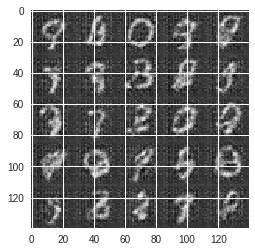

Epoch 2/2... Batches 40320/60000... Discriminator Loss: 0.1839... Generator Loss: 2.2528 Time_mins: 2
Epoch 2/2... Batches 42240/60000... Discriminator Loss: 0.4147... Generator Loss: 3.2186 Time_mins: 2
Epoch 2/2... Batches 44160/60000... Discriminator Loss: 0.2081... Generator Loss: 2.3096 Time_mins: 2
Epoch 2/2... Batches 46080/60000... Discriminator Loss: 0.3594... Generator Loss: 1.4837 Time_mins: 3
Epoch 2/2... Batches 48000/60000... Discriminator Loss: 0.1011... Generator Loss: 2.8147 Time_mins: 3
Epoch 2/2... Batches 49920/60000... Discriminator Loss: 0.0151... Generator Loss: 6.8185 Time_mins: 3
Epoch 2/2... Batches 51840/60000... Discriminator Loss: 0.8724... Generator Loss: 1.1642 Time_mins: 3
Epoch 2/2... Batches 53760/60000... Discriminator Loss: 0.4617... Generator Loss: 1.8747 Time_mins: 3
Epoch 2/2... Batches 55680/60000... Discriminator Loss: 0.5292... Generator Loss: 1.5840 Time_mins: 3
Epoch 2/2... Batches 57600/60000... Discriminator Loss: 0.1154... Generator Loss: 

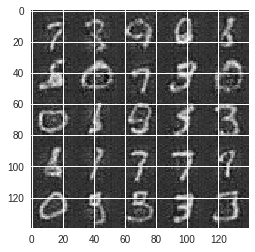

Epoch 2/2... Batches 59520/60000... Discriminator Loss: 0.1733... Generator Loss: 2.5687 Time_mins: 3


In [125]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Batches 3840/202599... Discriminator Loss: 0.0740... Generator Loss: 3.4347 Time_mins: 0
Epoch 1/2... Batches 7680/202599... Discriminator Loss: 0.5100... Generator Loss: 3.0136 Time_mins: 0
Epoch 1/2... Batches 11520/202599... Discriminator Loss: 6.0891... Generator Loss: 0.1282 Time_mins: 1
Epoch 1/2... Batches 15360/202599... Discriminator Loss: 0.3984... Generator Loss: 1.6257 Time_mins: 1
Epoch 1/2... Batches 19200/202599... Discriminator Loss: 0.2309... Generator Loss: 2.8402 Time_mins: 1
Epoch 1/2... Batches 23040/202599... Discriminator Loss: 0.1022... Generator Loss: 2.4602 Time_mins: 1


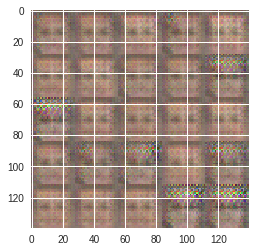

Epoch 1/2... Batches 26880/202599... Discriminator Loss: 1.5048... Generator Loss: 0.6340 Time_mins: 1
Epoch 1/2... Batches 30720/202599... Discriminator Loss: 1.1297... Generator Loss: 0.4632 Time_mins: 1
Epoch 1/2... Batches 34560/202599... Discriminator Loss: 1.0940... Generator Loss: 0.9512 Time_mins: 2
Epoch 1/2... Batches 38400/202599... Discriminator Loss: 0.0553... Generator Loss: 4.4174 Time_mins: 2
Epoch 1/2... Batches 42240/202599... Discriminator Loss: 0.4738... Generator Loss: 1.4271 Time_mins: 2
Epoch 1/2... Batches 46080/202599... Discriminator Loss: 0.7973... Generator Loss: 1.0802 Time_mins: 2


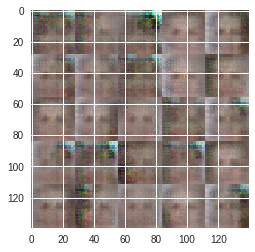

Epoch 1/2... Batches 49920/202599... Discriminator Loss: 1.1771... Generator Loss: 1.2829 Time_mins: 2
Epoch 1/2... Batches 53760/202599... Discriminator Loss: 1.2947... Generator Loss: 0.5487 Time_mins: 2
Epoch 1/2... Batches 57600/202599... Discriminator Loss: 1.2426... Generator Loss: 0.7519 Time_mins: 2
Epoch 1/2... Batches 61440/202599... Discriminator Loss: 1.1225... Generator Loss: 0.8146 Time_mins: 3
Epoch 1/2... Batches 65280/202599... Discriminator Loss: 1.2997... Generator Loss: 0.7686 Time_mins: 3
Epoch 1/2... Batches 69120/202599... Discriminator Loss: 0.3219... Generator Loss: 2.9228 Time_mins: 3


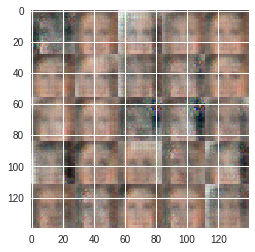

Epoch 1/2... Batches 72960/202599... Discriminator Loss: 0.0239... Generator Loss: 5.3977 Time_mins: 3
Epoch 1/2... Batches 76800/202599... Discriminator Loss: 0.0232... Generator Loss: 4.0044 Time_mins: 3
Epoch 1/2... Batches 80640/202599... Discriminator Loss: 1.8479... Generator Loss: 1.2304 Time_mins: 3
Epoch 1/2... Batches 84480/202599... Discriminator Loss: 0.9408... Generator Loss: 1.7732 Time_mins: 4
Epoch 1/2... Batches 88320/202599... Discriminator Loss: 0.2893... Generator Loss: 1.5847 Time_mins: 4
Epoch 1/2... Batches 92160/202599... Discriminator Loss: 1.3547... Generator Loss: 0.7013 Time_mins: 4


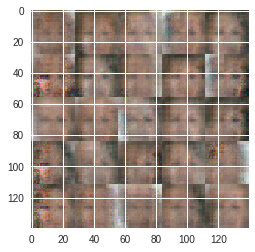

Epoch 1/2... Batches 96000/202599... Discriminator Loss: 1.0122... Generator Loss: 0.7343 Time_mins: 4
Epoch 1/2... Batches 99840/202599... Discriminator Loss: 1.3942... Generator Loss: 0.7416 Time_mins: 4
Epoch 1/2... Batches 103680/202599... Discriminator Loss: 1.1948... Generator Loss: 0.9682 Time_mins: 4
Epoch 1/2... Batches 107520/202599... Discriminator Loss: 1.4059... Generator Loss: 0.6551 Time_mins: 4
Epoch 1/2... Batches 111360/202599... Discriminator Loss: 0.9454... Generator Loss: 0.9865 Time_mins: 5
Epoch 1/2... Batches 115200/202599... Discriminator Loss: 0.1198... Generator Loss: 5.4471 Time_mins: 5


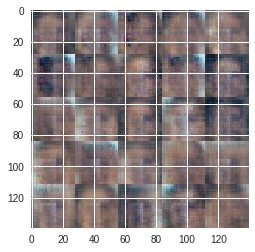

Epoch 1/2... Batches 119040/202599... Discriminator Loss: 0.9106... Generator Loss: 1.1000 Time_mins: 5
Epoch 1/2... Batches 122880/202599... Discriminator Loss: 1.0613... Generator Loss: 0.8119 Time_mins: 5
Epoch 1/2... Batches 126720/202599... Discriminator Loss: 1.1196... Generator Loss: 1.0597 Time_mins: 5
Epoch 1/2... Batches 130560/202599... Discriminator Loss: 1.5772... Generator Loss: 0.2931 Time_mins: 5
Epoch 1/2... Batches 134400/202599... Discriminator Loss: 0.7694... Generator Loss: 0.7205 Time_mins: 6
Epoch 1/2... Batches 138240/202599... Discriminator Loss: 0.3682... Generator Loss: 2.6914 Time_mins: 6


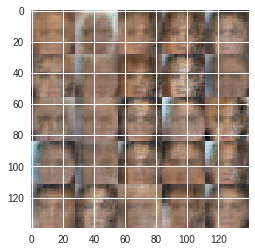

Epoch 1/2... Batches 142080/202599... Discriminator Loss: 0.6914... Generator Loss: 1.7217 Time_mins: 6
Epoch 1/2... Batches 145920/202599... Discriminator Loss: 0.0424... Generator Loss: 3.9755 Time_mins: 6
Epoch 1/2... Batches 149760/202599... Discriminator Loss: 0.5786... Generator Loss: 1.5586 Time_mins: 6
Epoch 1/2... Batches 153600/202599... Discriminator Loss: 0.9000... Generator Loss: 1.2512 Time_mins: 6
Epoch 1/2... Batches 157440/202599... Discriminator Loss: 0.7981... Generator Loss: 0.8997 Time_mins: 6
Epoch 1/2... Batches 161280/202599... Discriminator Loss: 0.4331... Generator Loss: 1.3383 Time_mins: 7


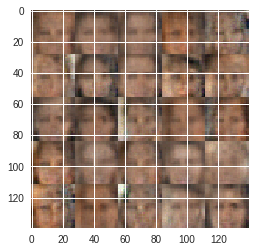

Epoch 1/2... Batches 165120/202599... Discriminator Loss: 2.4281... Generator Loss: 4.5412 Time_mins: 7
Epoch 1/2... Batches 168960/202599... Discriminator Loss: 0.5333... Generator Loss: 1.5970 Time_mins: 7
Epoch 1/2... Batches 172800/202599... Discriminator Loss: 0.8147... Generator Loss: 0.9815 Time_mins: 7
Epoch 1/2... Batches 176640/202599... Discriminator Loss: 0.9682... Generator Loss: 0.8482 Time_mins: 7
Epoch 1/2... Batches 180480/202599... Discriminator Loss: 0.3514... Generator Loss: 1.7939 Time_mins: 7
Epoch 1/2... Batches 184320/202599... Discriminator Loss: 0.2111... Generator Loss: 2.8443 Time_mins: 8


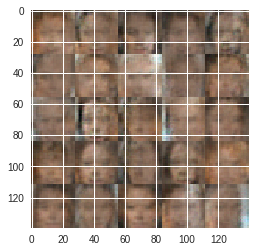

Epoch 1/2... Batches 188160/202599... Discriminator Loss: 0.5052... Generator Loss: 1.2682 Time_mins: 8
Epoch 1/2... Batches 192000/202599... Discriminator Loss: 0.9651... Generator Loss: 2.4100 Time_mins: 8
Epoch 1/2... Batches 195840/202599... Discriminator Loss: 0.5274... Generator Loss: 1.1653 Time_mins: 8
Epoch 1/2... Batches 199680/202599... Discriminator Loss: 0.5092... Generator Loss: 1.2559 Time_mins: 8
Epoch 2/2... Batches 101760/202599... Discriminator Loss: 1.1154... Generator Loss: 2.1908 Time_mins: 8
Epoch 2/2... Batches 103680/202599... Discriminator Loss: 1.4707... Generator Loss: 0.3547 Time_mins: 8


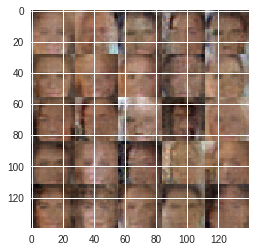

Epoch 2/2... Batches 105600/202599... Discriminator Loss: 0.3307... Generator Loss: 1.6815 Time_mins: 9
Epoch 2/2... Batches 107520/202599... Discriminator Loss: 0.6984... Generator Loss: 1.0294 Time_mins: 9
Epoch 2/2... Batches 109440/202599... Discriminator Loss: 0.6840... Generator Loss: 1.4677 Time_mins: 9
Epoch 2/2... Batches 111360/202599... Discriminator Loss: 0.5121... Generator Loss: 1.2592 Time_mins: 9
Epoch 2/2... Batches 113280/202599... Discriminator Loss: 0.3703... Generator Loss: 1.6900 Time_mins: 9
Epoch 2/2... Batches 115200/202599... Discriminator Loss: 0.2511... Generator Loss: 2.3581 Time_mins: 9


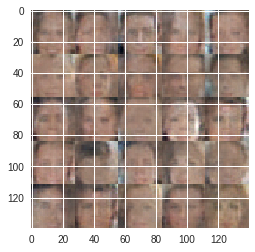

Epoch 2/2... Batches 117120/202599... Discriminator Loss: 0.4782... Generator Loss: 1.5944 Time_mins: 10
Epoch 2/2... Batches 119040/202599... Discriminator Loss: 0.8158... Generator Loss: 0.9860 Time_mins: 10
Epoch 2/2... Batches 120960/202599... Discriminator Loss: 0.8383... Generator Loss: 2.5275 Time_mins: 10
Epoch 2/2... Batches 122880/202599... Discriminator Loss: 1.0607... Generator Loss: 0.6604 Time_mins: 10
Epoch 2/2... Batches 124800/202599... Discriminator Loss: 1.1113... Generator Loss: 3.0429 Time_mins: 10
Epoch 2/2... Batches 126720/202599... Discriminator Loss: 2.0036... Generator Loss: 2.3978 Time_mins: 10


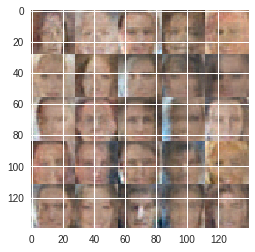

Epoch 2/2... Batches 128640/202599... Discriminator Loss: 0.7279... Generator Loss: 1.4906 Time_mins: 10
Epoch 2/2... Batches 130560/202599... Discriminator Loss: 0.4853... Generator Loss: 1.2937 Time_mins: 11
Epoch 2/2... Batches 132480/202599... Discriminator Loss: 1.1037... Generator Loss: 3.6827 Time_mins: 11
Epoch 2/2... Batches 134400/202599... Discriminator Loss: 1.0668... Generator Loss: 0.7449 Time_mins: 11
Epoch 2/2... Batches 136320/202599... Discriminator Loss: 0.7052... Generator Loss: 1.2373 Time_mins: 11
Epoch 2/2... Batches 138240/202599... Discriminator Loss: 1.2864... Generator Loss: 0.5384 Time_mins: 11


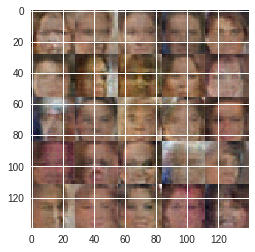

Epoch 2/2... Batches 140160/202599... Discriminator Loss: 1.0519... Generator Loss: 0.7090 Time_mins: 11
Epoch 2/2... Batches 142080/202599... Discriminator Loss: 0.8080... Generator Loss: 0.8615 Time_mins: 12
Epoch 2/2... Batches 144000/202599... Discriminator Loss: 0.9615... Generator Loss: 0.6651 Time_mins: 12
Epoch 2/2... Batches 145920/202599... Discriminator Loss: 1.0288... Generator Loss: 0.6493 Time_mins: 12
Epoch 2/2... Batches 147840/202599... Discriminator Loss: 1.1462... Generator Loss: 0.6363 Time_mins: 12
Epoch 2/2... Batches 149760/202599... Discriminator Loss: 2.3411... Generator Loss: 4.2073 Time_mins: 12


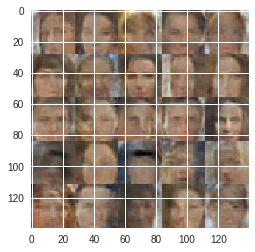

Epoch 2/2... Batches 151680/202599... Discriminator Loss: 0.6201... Generator Loss: 1.2735 Time_mins: 12
Epoch 2/2... Batches 153600/202599... Discriminator Loss: 1.1715... Generator Loss: 0.5416 Time_mins: 12
Epoch 2/2... Batches 155520/202599... Discriminator Loss: 0.9216... Generator Loss: 0.7685 Time_mins: 13
Epoch 2/2... Batches 157440/202599... Discriminator Loss: 0.5222... Generator Loss: 1.9176 Time_mins: 13
Epoch 2/2... Batches 159360/202599... Discriminator Loss: 1.1248... Generator Loss: 0.5915 Time_mins: 13
Epoch 2/2... Batches 161280/202599... Discriminator Loss: 0.8249... Generator Loss: 1.1023 Time_mins: 13


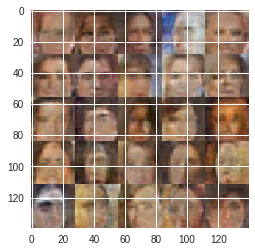

Epoch 2/2... Batches 163200/202599... Discriminator Loss: 0.5712... Generator Loss: 1.3687 Time_mins: 13
Epoch 2/2... Batches 165120/202599... Discriminator Loss: 0.7340... Generator Loss: 1.0372 Time_mins: 13
Epoch 2/2... Batches 167040/202599... Discriminator Loss: 1.1181... Generator Loss: 0.5267 Time_mins: 14
Epoch 2/2... Batches 168960/202599... Discriminator Loss: 2.1600... Generator Loss: 0.1878 Time_mins: 14
Epoch 2/2... Batches 170880/202599... Discriminator Loss: 0.7501... Generator Loss: 1.0949 Time_mins: 14
Epoch 2/2... Batches 172800/202599... Discriminator Loss: 1.3369... Generator Loss: 0.4292 Time_mins: 14


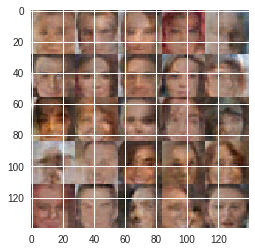

Epoch 2/2... Batches 174720/202599... Discriminator Loss: 0.6822... Generator Loss: 2.2804 Time_mins: 14
Epoch 2/2... Batches 176640/202599... Discriminator Loss: 1.4288... Generator Loss: 0.3940 Time_mins: 14
Epoch 2/2... Batches 178560/202599... Discriminator Loss: 0.7069... Generator Loss: 1.0535 Time_mins: 14
Epoch 2/2... Batches 180480/202599... Discriminator Loss: 1.0533... Generator Loss: 0.6173 Time_mins: 15
Epoch 2/2... Batches 182400/202599... Discriminator Loss: 0.7540... Generator Loss: 1.4466 Time_mins: 15
Epoch 2/2... Batches 184320/202599... Discriminator Loss: 0.6839... Generator Loss: 3.3623 Time_mins: 15


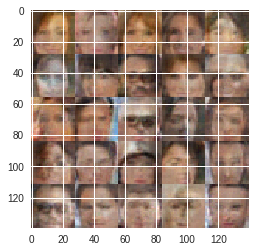

Epoch 2/2... Batches 186240/202599... Discriminator Loss: 0.7114... Generator Loss: 1.0503 Time_mins: 15
Epoch 2/2... Batches 188160/202599... Discriminator Loss: 0.7554... Generator Loss: 1.1009 Time_mins: 15
Epoch 2/2... Batches 190080/202599... Discriminator Loss: 0.5190... Generator Loss: 1.3816 Time_mins: 15
Epoch 2/2... Batches 192000/202599... Discriminator Loss: 0.4238... Generator Loss: 2.3283 Time_mins: 15
Epoch 2/2... Batches 193920/202599... Discriminator Loss: 1.0991... Generator Loss: 0.5991 Time_mins: 16
Epoch 2/2... Batches 195840/202599... Discriminator Loss: 0.7136... Generator Loss: 0.9727 Time_mins: 16


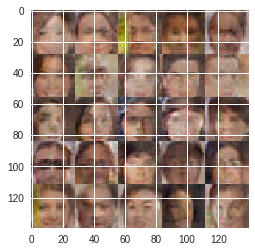

Epoch 2/2... Batches 197760/202599... Discriminator Loss: 1.3380... Generator Loss: 0.4414 Time_mins: 16
Epoch 2/2... Batches 199680/202599... Discriminator Loss: 0.9030... Generator Loss: 1.1592 Time_mins: 16
Epoch 2/2... Batches 201600/202599... Discriminator Loss: 0.7816... Generator Loss: 0.9553 Time_mins: 16


In [122]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5
tf.reset_default_graph

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.